In [142]:
import cv2 as cv
import matplotlib.pyplot as plt
from skimage import data, color
import skimage
from skimage.transform import rescale, resize, downscale_local_mean


In [143]:
# importing the libraries for xml file
import elementpath
import lxml.etree as etree
import lxml
import numpy as np
import pandas as pd

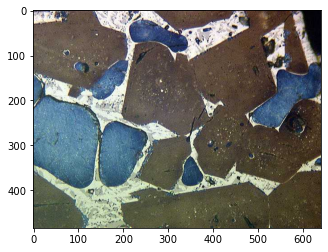

In [144]:
# uploading image and reading it
img_number = "002"
img_name = "img {}.jpg".format(img_number)
img_path = 'images/{}'.format(img_name)
img = plt.imread(img_path)
plt.imshow(img)
#plt.axis("off")
plt.show()
height, width,_ = img.shape

In [145]:
#code for checking negative values
sum(img[:,:,2].flatten()<0)

0

In [146]:
# reading the annot
root = etree.parse('annotations.xml').getroot()


In [147]:
labels = {"Alite":0, "Belite":1, "Aluminate":2, "Ferrite":3, "Others":4}
#dictionary for label colors
colors = {"Alite":(102,102,255), "Belite":(192,192,192), "Aluminate":(64,64,64), "Ferrite":(0,0,0), "Others":(10,10,10)}
List = ["Alite", "Belite", "Aluminate", "Ferrite", "Others"]

In [148]:
# creating a list to convert the xml file into a list
anno = []
# giving image name
image_name_attr = ".//image[@name='{}']".format(img_name) # img_path  = "img 002.jpg"
for image_tag in root.iterfind(image_name_attr):
    image = {}
    for key, value in image_tag.items():
#        print(key,value)
        image[key] = value
    image["shapes"] = []
    for polygon_tag in image_tag.iter("polygon"):
        polygon = {"type":"polygon"}
        polygon['label'] = polygon_tag.get('label')
        polygon["points"] = polygon_tag.get("points")
        image['shapes'].append(polygon)
    anno.append(image)


In [149]:
# To create a mask of xml file
scale_factor = 1
def create_mask_file(anno):
    height = int(anno[0]["height"])
    width = int(anno[0]["width"])
#defining background
    background = np.zeros((height, width, 3), np.uint8)
    mask = np.full((height, width, 3), background, dtype=np.uint8)
    shapes = anno[0]["shapes"]
    for shape in shapes:
        points = []
        points = [tuple(map(float, p.split(','))) for p in shape['points'].split(';')]
        points = np.array([(int(p[0]), int(p[1])) for p in points])
        points = points.astype(int)
        label_color = colors[shape["label"]]            
        mask = cv.drawContours(mask, [points], -1, color=(255, 255, 255), thickness=0)
        mask = cv.fillPoly(mask, [points], color=label_color)
    return mask

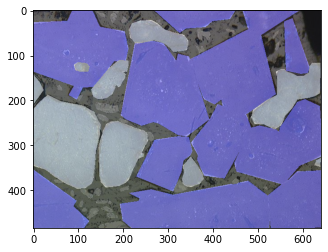

In [150]:
back_gr = create_mask_file(anno)
plt.imshow(img,alpha=0.8)
plt.imshow(back_gr,cmap='Reds',alpha=0.6)
plt.show()

In [153]:
# Now comes the training Part ... Are you ready?
### if yes then please enter the value
roi1 = [100,200,150,250]
roi2 = [100,200,500,600]
roi3 = [300,400,300,400]
roi4 = [320,480,100,200]
roi5 = [380,480,500,600]

imgplay = img.copy()
img_tr = img.copy()
grid_size=1
numbands =3
y = []
imgdata=[]

rois =[roi1,roi2,roi3,roi4,roi5]

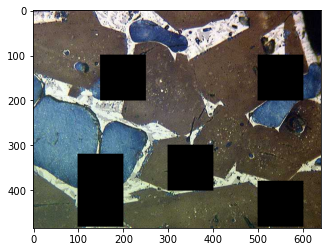

In [152]:
for roi in rois: 
    ylabel=[]
    for i in range(roi[0],roi[1]):
        for j in range (roi[2],roi[3]):
            pxp = i+grid_size+1
            pxm = i-grid_size

            pyp = j+grid_size+1
            pym = j-grid_size
#            print(image_mask[i,j])
# Printing the window
#            img_tr[pxp:pxm,pyl:pyu] = (0,0,0)
            ylabel.append(list(colors.keys())[list(colors.values()).index(tuple(back_gr[i,j]))])
            
            data_input = [] #if numbands > 1 then uncomment it
            flat_2 = []
            for k in range(numbands):
                flat = imgplay[pxm:pxp,pym:pyp,k].flatten()
#                print(flat)
#                flat_2.append(flat)
                flat_2 = flat_2 + list(flat)
            imgdata.append(np.array(flat_2,dtype='uint32'))
            img_tr[pxm:pxp,pym:pyp] = (0,0,0)
    y = y + list(ylabel)
plt.imshow(img_tr)
x = pd.DataFrame(imgdata).fillna(0)
df = pd.DataFrame(imgdata).fillna(0)
df["y"] = y

In [140]:
pd.Series(y).value_counts()


Alite        24998
Belite       15388
Ferrite      12999
Aluminate     2615
dtype: int64

In [141]:
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [92]:
# model = MLPClassifier(hidden_layer_sizes=(100,),max_iter=1000,activation='relu',alpha=1e-2,learning_rate_init=1e-5).fit(x,y)
#99
model = MLPClassifier(hidden_layer_sizes=(15,2),alpha=0.01,max_iter=10000,random_state=1991).fit(x,y)#for small square in left
# model = MLPClassifier(hidden_layer_sizes=(10,),alpha=0.00001,validation_fraction=0.2,learning_rate='adaptive',
#                       activation='relu',max_iter=1000,random_state=2).fit(x,y)

modelx = XGBClassifier(n_estimators=5).fit(x,y)
# ypred = model.predict(x)

e:\python\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:09:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


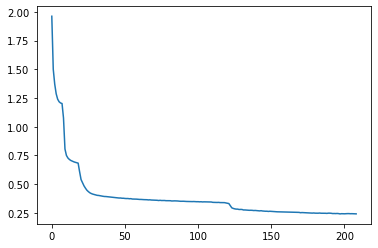

In [93]:
plt.plot(model.loss_curve_)

In [94]:
ypred = model.predict(x)
ypredx = modelx.predict(x)
from sklearn.metrics import classification_report
print(classification_report(y,ypred))
print(classification_report(y,ypredx))


              precision    recall  f1-score   support

       Alite       0.94      0.97      0.96     24998
   Aluminate       0.53      0.23      0.32      2615
      Belite       0.98      0.94      0.96     15388
     Ferrite       0.78      0.86      0.82     12999

    accuracy                           0.90     56000
   macro avg       0.81      0.75      0.76     56000
weighted avg       0.90      0.90      0.90     56000

              precision    recall  f1-score   support

       Alite       0.96      0.96      0.96     24998
   Aluminate       0.76      0.55      0.64      2615
      Belite       0.96      0.97      0.97     15388
     Ferrite       0.85      0.88      0.87     12999

    accuracy                           0.93     56000
   macro avg       0.88      0.84      0.86     56000
weighted avg       0.93      0.93      0.93     56000



In [116]:
df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,y
0,125,103,102,119,110,108,93,103,129,108,...,98,76,75,92,83,81,66,76,102,Alite
1,103,102,105,110,108,106,103,129,111,86,...,76,75,78,83,81,79,76,102,84,Alite
2,102,105,107,108,106,106,129,111,110,85,...,75,78,80,81,79,79,102,84,83,Alite
3,105,107,106,106,106,104,111,110,107,88,...,78,80,79,79,79,77,84,83,80,Alite
4,107,106,102,106,104,101,110,107,105,90,...,80,79,75,79,77,74,83,80,78,Alite
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55995,76,66,62,81,65,64,78,68,81,60,...,45,35,31,49,33,32,40,30,43,Alite
55996,66,62,69,65,64,82,68,81,80,50,...,35,31,38,33,32,50,30,43,42,Alite
55997,62,69,74,64,82,91,81,80,49,46,...,31,38,43,32,50,59,43,42,11,Alite
55998,69,74,74,82,91,86,80,49,72,53,...,38,43,43,50,59,54,42,11,34,Alite


In [112]:
# To save dataframe named as img 002.csv
df.to_csv("img {}.csv".format(img_number))

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,y
0,0,125,103,102,119,110,108,93,103,129,...,98,76,75,92,83,81,66,76,102,Alite
1,1,103,102,105,110,108,106,103,129,111,...,76,75,78,83,81,79,76,102,84,Alite
2,2,102,105,107,108,106,106,129,111,110,...,75,78,80,81,79,79,102,84,83,Alite
3,3,105,107,106,106,106,104,111,110,107,...,78,80,79,79,79,77,84,83,80,Alite
4,4,107,106,102,106,104,101,110,107,105,...,80,79,75,79,77,74,83,80,78,Alite
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55995,55995,76,66,62,81,65,64,78,68,81,...,45,35,31,49,33,32,40,30,43,Alite
55996,55996,66,62,69,65,64,82,68,81,80,...,35,31,38,33,32,50,30,43,42,Alite
55997,55997,62,69,74,64,82,91,81,80,49,...,31,38,43,32,50,59,43,42,11,Alite
55998,55998,69,74,74,82,91,86,80,49,72,...,38,43,43,50,59,54,42,11,34,Alite
